In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [16]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [17]:

def create_weekdays_december_january_dataframe():
    start_date = datetime(2023, 12, 16)
    end_date = datetime(2024, 1, 31)
    date_range = pd.date_range(start_date, end_date)
    df = pd.DataFrame({"Date": date_range})
    df = df[(df["Date"].dt.dayofweek != 5) & (df["Date"].dt.dayofweek != 6)]
    new_df = pd.DataFrame({"Date": df["Date"].dt.strftime('%Y-%m-%d')})
    new_df = new_df.head(30)
    return new_df

In [18]:
data = pd.read_csv('VNI.csv')
data = convert_raw_data(data)
data = data.dropna() # Drop missing values
data = data.reset_index(drop=True) # Reset the index

data

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,517.05,501.74,517.05,501.74,44.92K,4.50%
1,2010-01-05,532.53,529.23,539.39,529.23,70.05K,2.99%
2,2010-01-06,534.46,529.47,538.84,526.37,67.36K,0.36%
3,2010-01-07,533.34,536.78,540.77,530.68,75.68K,-0.21%
4,2010-01-08,520.90,540.95,544.49,520.90,84.72K,-2.33%
...,...,...,...,...,...,...,...
3478,2023-12-11,1125.50,1124.44,1129.15,1120.32,700.59K,0.09%
3479,2023-12-12,1127.63,1125.50,1129.77,1123.35,645.62K,0.19%
3480,2023-12-13,1114.20,1127.63,1131.21,1112.08,844.04K,-1.19%
3481,2023-12-14,1110.13,1114.20,1120.36,1107.86,681.02K,-0.37%


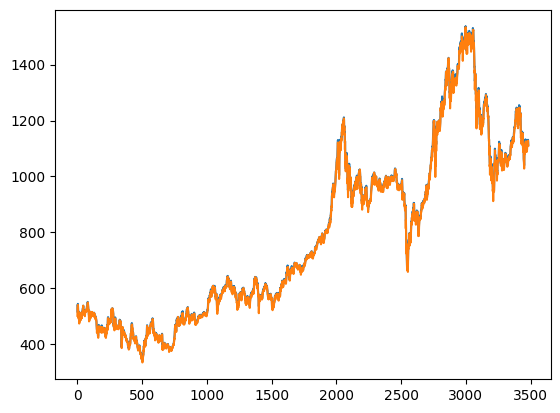

In [19]:
# gán biến
y = data[['Open']] # chuỗi thời gian cần dự báo (biến phụ thuộc)
X = data[['High']] # các biến độc lập



plt.plot(X)
plt.plot(y)
plt.show()

In [20]:
# chia train, test
# ratio = 0.7
# ratio = 0.8
ratio = 0.9

train_size = int(ratio * len(data))
test_size = int((1-ratio) * len(data))


train_data = data[:train_size]
test_data = data[train_size:]

y_train = y[:train_size]
X_train = X[:train_size]
y_test = y[train_size:]
X_test = X[train_size:]

In [21]:

svr_modal = SVR(kernel='rbf')
svr_modal.fit(X_train, y_train)



SVR()

In [22]:
# dự đoán giá đóng cửa của HNX trên tập kiểm tra

y_pred_sigmoid = svr_modal.predict(X_test)
y_pred_sigmoid= y_pred_sigmoid.reshape(-1,1)

In [23]:

mae = mean_absolute_error(y_test, y_pred_sigmoid)
mse = mean_squared_error(y_test, y_pred_sigmoid)
mape = mean_absolute_percentage_error(y_test, y_pred_sigmoid)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 17.058188360989732
MSE: 705.190626481252
RMSE: 26.55542555639529
MAPE: 0.014451356484822335


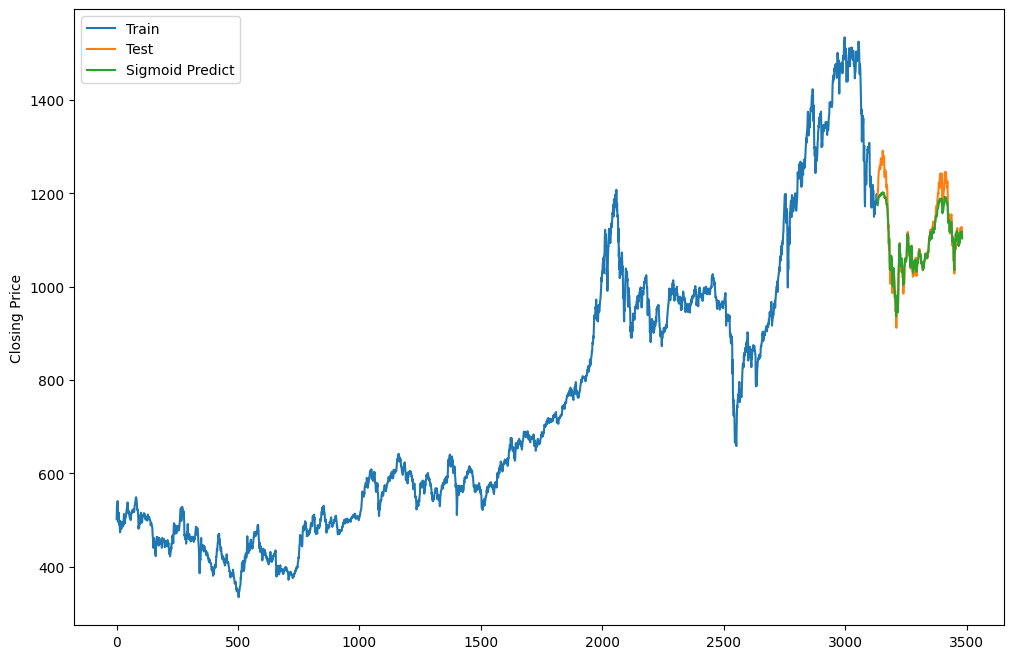

In [24]:
#vẽ mô hình
plt.figure(figsize=(12, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(X_test.index, y_pred_sigmoid, label='Sigmoid Predict')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [25]:
# láy giá trị Close của ngày cuối cùng trong dataset
last_row = data.tail(1)
last_data = last_row['Open'].values.reshape(-1,1)
last_data

array([[1110.13]])

In [26]:
x_next_30_day_sigmoid = []

# predict giá Close 30 ngày tiếp theo dựa vào giá Close của ngày trước đó
for i in range(30):
    x_pred_next = svr_modal.predict(last_data)
    x_next_30_day_sigmoid.append(x_pred_next)
    last_data = x_pred_next.reshape(-1,1)

print(x_next_30_day_sigmoid)

[array([1100.91535804]), array([1092.88111851]), array([1085.72600376]), array([1079.24414488]), array([1073.2887564]), array([1067.75150495]), array([1062.55009692]), array([1057.62045542]), array([1052.91159706]), array([1048.38216687]), array([1043.9980299]), array([1039.73055737]), array([1035.55538248]), array([1031.45148164]), array([1027.40048614]), array([1023.38616078]), array([1019.39400575]), array([1015.41095142]), array([1011.42512457]), array([1007.42567105]), array([1003.4026236]), array([999.34680714]), array([995.24977571]), array([991.10377675]), array([986.90173976]), array([982.63728656]), array([978.30476141]), array([973.89927884]), array([969.41678728]), array([964.85414615])]


In [27]:
predicted_date = create_weekdays_december_january_dataframe()
# predicted_date['Date'] = pd.to
future_30_days_df = pd.DataFrame()
future_30_days_df["Open sigmoid"] = pd.DataFrame(np.concatenate(x_next_30_day_sigmoid), index=predicted_date["Date"], columns=["Open sigmoid"])

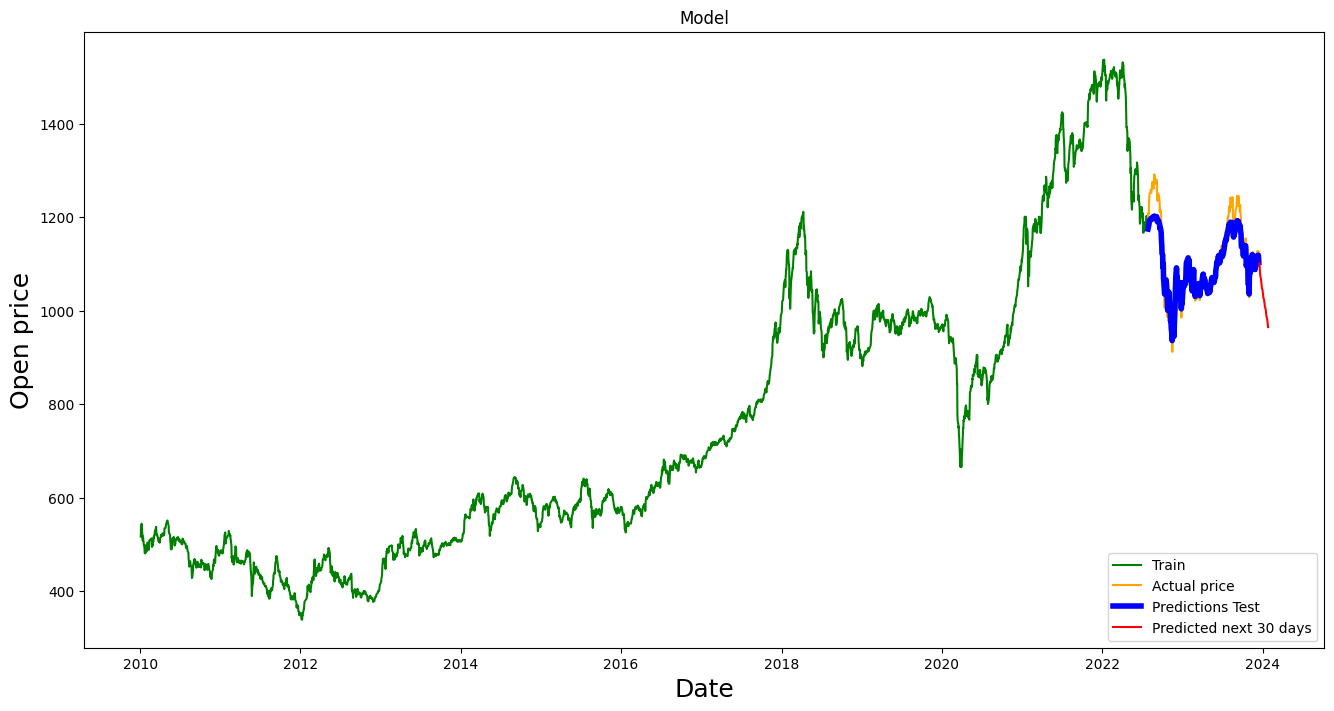

In [28]:
predicted_date = create_weekdays_december_january_dataframe()
future_30_days_df = pd.DataFrame(x_next_30_day_sigmoid, index=predicted_date["Date"], columns=["Open"])
future_30_days_df.index = pd.to_datetime(future_30_days_df.index)

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open price', fontsize=18)
plt.plot(train_data["Date"], X_train, color='green')
plt.plot(test_data["Date"], test_data["Open"], color='orange')
plt.plot(test_data["Date"],y_pred_sigmoid, color='blue', lw=4)
plt.plot(future_30_days_df.index, future_30_days_df['Open'], label='Predicted next 30 days', color = 'red')
plt.legend(['Train','Actual price', 'Predictions Test', 'Predicted next 30 days'], loc='lower right')
plt.show()